# Coffea Analysis of a NanoAOD MC dataset for CMS Run II (2016)

## Imports & reading

In [20]:
# imports

import uproot
import numpy as np
import awkward as ak
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use([hep.style.CMS])
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import ROOT as r

In [21]:
# read the file

events = NanoEventsFactory.from_root('GluGluToH_HToJPsiG_JPsiToMuMu_TuneCP5_13TeV-madgraph-pythia8_RunIISummer20UL16_Skim.root', schemaclass = NanoAODSchema.v7, treepath='Events').events()

/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:200: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  warnings.warn(


In [22]:
# show the available contents for each of the events

events.fields

['genCosThetaStar',
 'lheWeight',
 'HT30',
 'centrality',
 'maxMuonPfSubIso',
 'photonWeight',
 'genTtbarId',
 'GenVtx',
 'HLT',
 'SoftActivityJetNjets10',
 'triggerWeightUp',
 'CaloMET',
 'GenIsolatedPhoton',
 'Photon',
 'trCentr',
 'btagWeight',
 'isJPsiTrigger',
 'event',
 'GenPart',
 'SoftActivityJet',
 'nCleanBTagJet',
 'HLTriggerFinalPath',
 'HLTriggerFirstPath',
 'triggerMuonEGWeightDown',
 'genCosTheta1',
 'Muon',
 'SoftActivityJetHT',
 'cosTheta1',
 'isDoubleMuonTrigger',
 'minMuonTrkSubIso',
 'LHE',
 'MET',
 'Tau',
 'photonWeightUp',
 'puWeightUp',
 'Photon1',
 'qcdnnloWeight',
 'TkMET',
 'LHEWeight',
 'triggerJPsiWeightDown',
 'leptonWeightDown',
 'Electron',
 'passedMETFilters',
 'is2018',
 'Muon2',
 'H',
 'L1Reco',
 'triggerWeight',
 'triggerWeightDown',
 'isSingleMuonTrigger',
 'Pileup',
 'ChsMET',
 'L1PreFiringWeight',
 'maxMuonTrkSubIso',
 'Muon12',
 'metPlusPhotonDPhi',
 'stitchWeight',
 'minMuonMetDPhi',
 'minMuonPfSubIso',
 'isSingleMuonPhotonTrigger',
 'is2016',
 'L

## Filtering the events

Selection cuts:
* Muons:
    * $ p_{T} > 18 \textrm{ }\mathrm{GeV}$
    * $|\eta| < 2.4$
* Gammas: $ p_{T} > 30 \textrm{ }\mathrm{GeV}$


In [108]:
leadingMuon_pt_cut = 17
subleadingMuon_pt_cut = 4
muon_eta_cut = 2.4
photon_pt_cut = 30

In [131]:
# declare the filters required for the events
'''
# muon filters
muon_filters = (events.Muon.pt > muon_pt_cut) & (abs(events.Muon.eta) < muon_eta_cut)
muon_filters = muon_filters & (events.Muon.pt < 10000) # somehow there is an event with a 10400 GeV pT muon

# photon filters
photon_filters = (events.Photon.pt > photon_pt_cut)


event_filters = ak.any(photon_filters, axis = -1) & ak.any(muon_filters, axis = -1) # the axis = -1 here allows us to go event by event
                                                                                    # so if theres AT LEAST a muon / photon if an event
                                                                                    # that satisfies the required cut
                                                                                    # then the event is kept

selected_events = events[event_filters] # these are the events that satisfy every requirement
print("The events that satisfy all the requirements are the %.1f%%" % (len(selected_events) / len(events) * 100))

'''
# muon filters
atLeast_one_muon_with_17GeV = ak.any(events.Muon.pt > leadingMuon_pt_cut, axis = -1)
atLeast_one_muon_with_4GeV = ak.any(events.Muon.pt > subleadingMuon_pt_cut, axis = -1)
muon_opposite_charges = ak.sum(events.Muon.charge, axis = -1) == 0

muon_filters = atLeast_one_muon_with_17GeV & atLeast_one_muon_with_4GeV & muon_opposite_charges




# selected events
event_filters = muon_filters # & photon_filters
selected_events = events[event_filters]

print("The events that satisfy all the requirements are the %.1f%%" % (len(selected_events) / len(events.Muon) * 100))


The events that satisfy all the requirements are the 84.1%


In [136]:
# apply the filters

selected_muons = events.Muon[muon_filters]
#selected_photons = events.Photon[photon_filters]

In [137]:
# info on the cuts efficiency

print("A total of", sum(ak.num(selected_muons)), "out of", sum(ak.num(events.Muon)), "muons (%.1f%%) passed the cuts." % (sum(ak.num(selected_muons))/sum(ak.num(events.Muon)) * 100))

A total of 886 out of 1134 muons (78.1%) passed the cuts.


## Plots

### Muon $p_{T}$

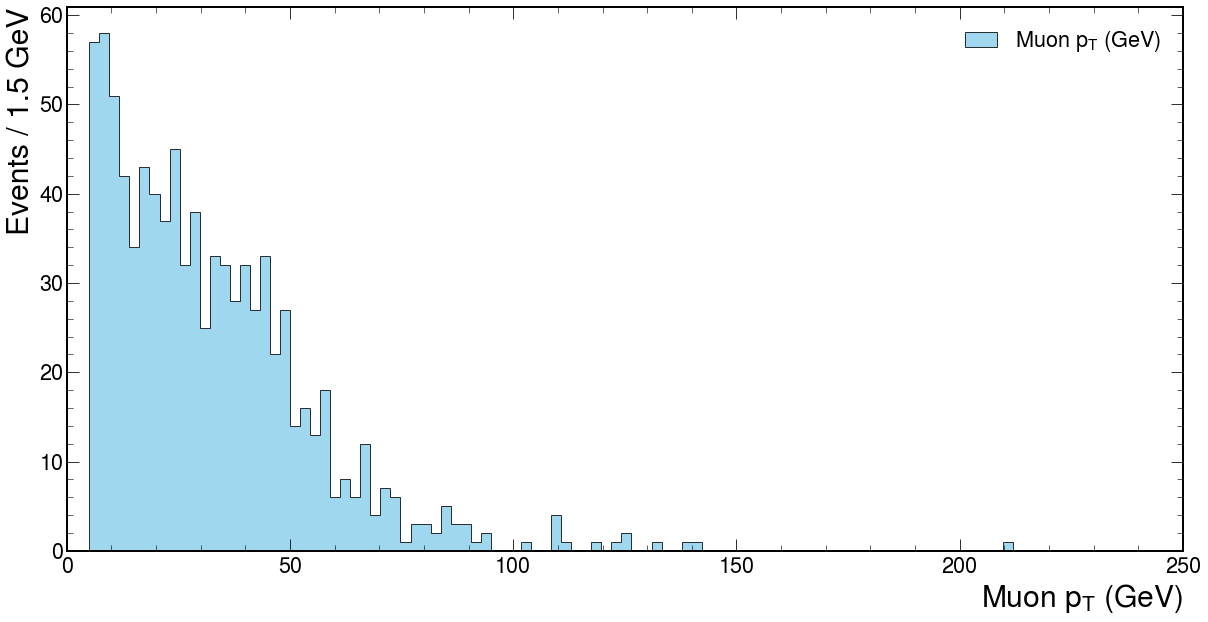

In [138]:
obs =  ak.flatten(selected_muons.pt, axis = None)

min = 0
max = 250
width = 1.5 # GeV

nbins = int(round((max - min) / width))

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "skyblue",
    alpha = 0.8,
    edgecolor = "black",
    label = r"Muon $p_{T}$ (GeV)"
)

ax.set_xlabel("Muon $p_{T}$ (GeV)", fontsize = 30)
ax.set_ylabel("Events / %.1f GeV" % width, fontsize = 30)
ax.set_xlim(min, max)
ax.legend()

### Photon $p_{T}$

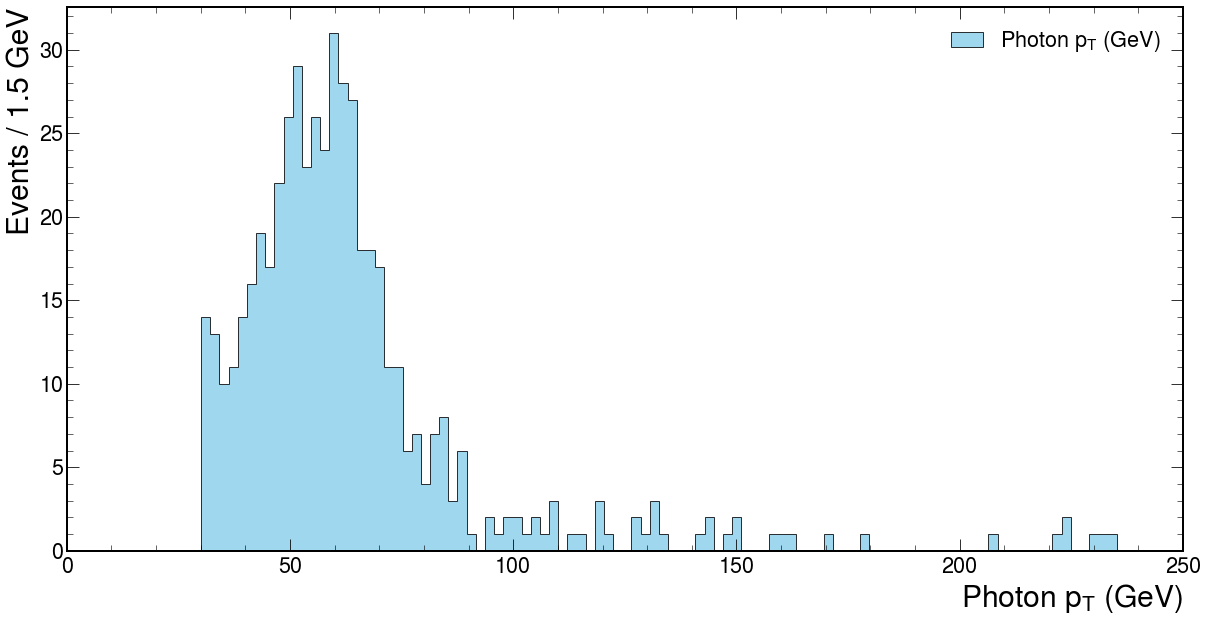

In [139]:
obs = ak.flatten(selected_photons.pt, axis = None)

min = 0
max = 250
width = 1.5 # GeV

nbins = int(round((max - min) / width))

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "skyblue",
    alpha = 0.8,
    edgecolor = "black",
    label = r"Photon $p_{T}$ (GeV)"
)
ax.set_xlabel("Photon $p_{T}$ (GeV)", fontsize = 30)
ax.set_ylabel("Events / %.1f GeV" % width, fontsize = 30)
ax.set_xlim(min, max)
ax.legend()

### Photon quality

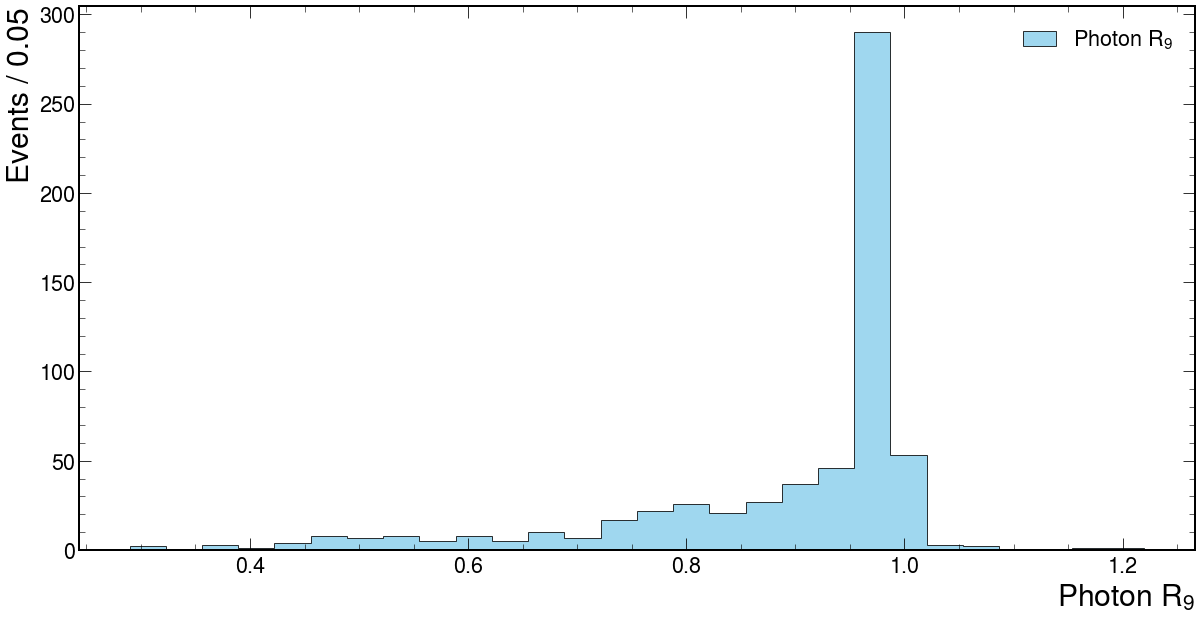

In [140]:
obs = ak.flatten(events.Photon.r9, axis = None)

min = 0
max = 1.4
width = 0.05

nbins = int(round((max - min) / width))

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "skyblue",
    alpha = 0.8,
    edgecolor = "black",
    label = r"Photon $R_{9}$"
)

ax.set_xlabel("Photon $R_{9}$", fontsize = 30)
ax.set_ylabel("Events / %.2f" % width, fontsize = 30)
#ax.set_xlim(min, max)
ax.legend()

### Invariant mass

In [141]:
muon_theta = 2 * np.tan(np.exp(-selected_events.Muon.eta))

In [142]:
muon_theta = 2 * np.arctan(np.exp(selected_events.Muon.eta))
muon_theta

<Array [[2.28, 2.23], ... [1.97, 1.84]] type='438 * var * float32'>

In [143]:
muon_P = selected_events.Muon.pt / np.sin(muon_theta)
muon_Px = muon_P * np.sin(muon_theta) * np.cos(selected_events.Muon.phi)
muon_Py = muon_P * np.sin(muon_theta) * np.sin(selected_events.Muon.phi)
muon_Pz = muon_P * np.cos(muon_theta)
muon_e = (selected_events.Muon.mass ** 2 + muon_P ** 2) ** 0.5

In [148]:
mumu_Px = ak.sum(muon_Px, axis = -1)
mumu_Py = ak.sum(muon_Py, axis = -1)
mumu_Pz = ak.sum(muon_Pz, axis = -1)

mumu_e = ak.sum(muon_e, axis = -1)

mumu_m = (mumu_e ** 2 - mumu_Px ** 2 - mumu_Py ** 2 - mumu_Pz ** 2) ** 0.5

In [150]:
mumu_m

<Array [3.11, 3.12, 3.06, ... 3.06, 3.07, 3.14] type='438 * float32'>

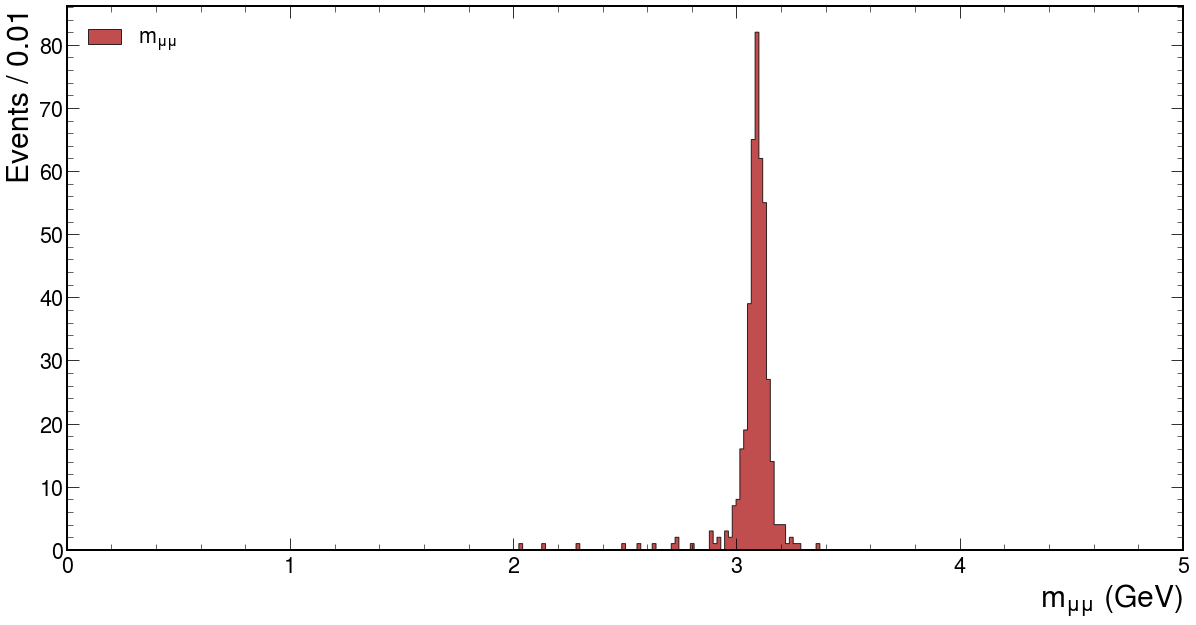

In [156]:
obs = ak.flatten(mumu_m, axis = None)

min = 0
max = 5
width = 0.01 # GeV

nbins = int(round((max - min) / width))

fig, ax = plt.subplots(figsize=(20, 10))
ax.hist(
    obs,
    bins = nbins,
    histtype = "stepfilled",
    color = "firebrick",
    alpha = 0.8,
    edgecolor = "black",
    label = r"$m_{\mu \mu}$"
)

ax.set_xlabel("$m_{\mu \mu}\ ({\\rm GeV})$", fontsize = 30)
ax.set_ylabel("Events / %.2f" % width, fontsize = 30)
ax.set_xlim(min, max)
ax.legend()

## Signal efficiency: efficiency of the trigger path (HLT_Mu17_Photon30) with respect to the desired signal

In [22]:
den = ak.sum( ak.any(events.Muon.pt > muon_pt_cut, axis = -1) & ak.any(events.Photon.pt > photon_pt_cut, axis = -1))
num = ak.sum( ak.any(events.Muon[events.HLT.Mu17_Photon30_CaloIdL_L1ISO].pt > muon_pt_cut, axis = -1) & ak.any(events.Photon[events.HLT.Mu17_Photon30_CaloIdL_L1ISO].pt > photon_pt_cut, axis = -1))

In [23]:
trig_eff = num / den * 100
print("The trigger efficiency is %.1f%%" % trig_eff)

The trigger efficiency is 87.8%
